# Welcome!
Below, we will learn to implement and train a policy to play atari-pong, using only the pixels as input. We will use convolutional neural nets, multiprocessing, and pytorch to implement and train our policy. Let's get started!

(I strongly recommend you to try this notebook on the Udacity workspace first before running it locally on your desktop/laptop, as performance might suffer in different environments)

In [1]:
# render open_ai gym environment
import gymnasium as gym

import torch
import torch.nn as nn
import torch.nn.functional as F
import random
import time
import numpy as np
import progressbar as pb
from collections import deque
import matplotlib.pyplot as plt
from matplotlib import animation
from JSAnimation.IPython_display import display_animation

%matplotlib inline
is_ipython = 'inline' in plt.get_backend()
if is_ipython:
    print("\tusing Ipython")
    from IPython.display import display
else:
    print("pyvirtualdisplay")
    #!python -m pip install pyvirtualdisplay
    from pyvirtualdisplay import Display
    display = Display(visible=0, size=(1400, 900))
    display.start()
ion_context = plt.ion()

from parallelEnv_X import parallelEnv

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("\tusing device:", device) 

	using Ipython
	using device: cuda:0


In [2]:
#[k for k in list(gym.envs.registry.keys()) if "Pong" in k]
parallelEnv

parallelEnv_X.parallelEnv

In [3]:
# PongDeterministic does not contain random frameskip
# so is faster to train than the vanilla Pong-v4 environment

env = gym.make('PongDeterministic-v4', render_mode='rgb_array')
#env = gym.make('Pong-v4', full_action_space=False, frameskip=1, render_mode='rgb_array', old_step_api=True)#, obs_type='grayscale'

print("List of available actions: ", env.unwrapped.get_action_meanings())

# we will only use the actions 'RIGHTFIRE' = 4 and 'LEFTFIRE" = 5
# the 'FIRE' part ensures that the game starts again after losing a life
# the actions are hard-coded in pong_utils.py
RIGHT=4
LEFT=5

List of available actions:  ['NOOP', 'FIRE', 'RIGHT', 'LEFT', 'RIGHTFIRE', 'LEFTFIRE']


# Utils

In [4]:
def output_volume(in_dims, k, s, p, transpose=False):
    ''' Calculate a convolutional layer's output size from input size
        and the layer's parameters:
        in_dims (int or tuple): input dimensions
        k (int or tuple): kernel size 
        s (int or tuple): stride
        p (int or tuple): padding 
    '''
    if not transpose:
    #convolution out
        try:
            out_size = int(np.floor((in_dims - k + 2*p)/s + 1))
        except:
            out_size = tuple(int(np.floor((idid - kk + 2*pp)/ss + 1)) if ss!=0 else None for idid, kk, ss, pp in zip(in_dims,k,s,p))
    
    else: 
    #deconvolution out
        try:
            out_size = int(np.floor((in_dims - 1)*s + k - 2*p))
        except:
            out_size = tuple(int(np.floor((idid - 1)*ss + kk - 2*pp)) for idid, kk, ss, pp in zip(in_dims,k,s,p))
        
    return out_size



In [29]:
for env in envs.env_fns:
    env.reset()
    print(env.step(4)[4])
envs.step([4]*nenvs)

{'lives': 0, 'episode_frame_number': 4, 'frame_number': 20}
{'lives': 0, 'episode_frame_number': 4, 'frame_number': 20}
{'lives': 0, 'episode_frame_number': 4, 'frame_number': 20}
{'lives': 0, 'episode_frame_number': 4, 'frame_number': 20}
{'lives': 0, 'episode_frame_number': 4, 'frame_number': 20}
{'lives': 0, 'episode_frame_number': 4, 'frame_number': 20}
{'lives': 0, 'episode_frame_number': 4, 'frame_number': 20}
{'lives': 0, 'episode_frame_number': 4, 'frame_number': 20}
{'lives': 0, 'episode_frame_number': 4, 'frame_number': 20}
{'lives': 0, 'episode_frame_number': 4, 'frame_number': 20}
{'lives': 0, 'episode_frame_number': 4, 'frame_number': 20}
{'lives': 0, 'episode_frame_number': 4, 'frame_number': 28}


BrokenPipeError: [WinError 232] The pipe is being closed

In [5]:
# preprocess a single frame: stack two imgs together, crop and downsample to 80x80
def preprocess_single(image, bkg_color = np.array([144, 72, 17])):
    img = np.mean(image[34:-16:2, ::2]-bkg_color, axis=-1)/255.
    return img # as an np.array

# convert outputs of parallelEnv to inputs to pytorch neural net
# this is useful for batch processing especially on the GPU
def preprocess_batch(images, bkg_color = np.array([144, 72, 17])):
    '''Specified to "properly convert two frames into shape (n, 2, 80, 80)" or (N,2,W,H)
        Called by: play(), collect_trajectories()
        PARAMS
        images (np.array): array of size (N, 2, W, H, C) where:
                                          N = number of contributing envs
                                          2 = two images, each shaped (W,H,C)
                                          W = Width of image
                                          H = height of image
                                          C = # color channels (1=None, or 3)                                      
        bkg_color (np.array): adjustment to subtract from each color channel shape (3,)
        RETURNS
        batch_input (np.array): shaped (N,2,80,80) and scaled to (0,1) values,
                                ready to be torched and sent to policy
    '''
    if len(images.shape) < 5:              # if shape not (N,2,W,H,C) then:
        images = np.expand_dims(images, 0) # expand to (1,2,W,H,C) 
    # subtract bkg and crop
    batch_input = images[:, :, 34:-16:2, ::2]-bkg_color
    # average over last axis (the r, g, and b color channels)
    batch_input = np.mean(batch_input, axis=-1)/255. #shape now (N,2,80,80)
    return batch_input  # returns an np.array 
                        # note NOT torch.from_numpy().float().to(device)

# convert states to probability, passing through the policy
def states_to_probs(policy, states):
    '''Only called from clipped_surrogate
       Only this fxn and collect_T() call Policy
       !!! Backwards grad only applied here !!!
       Takes states, a tensor of preprocessed rgb-tensors on cuda, and
             policy, a CNN on cuda
       Returns policy outputs, still as a tensor on cuda
       '''
    policy_input = states.view(-1, *states.shape[-3:]) #
    probs = policy(policy_input)
    return probs.view(states.shape[:-3])  #cuda tensor -->

# collect trajectories for a parallelized parallelEnv object
def collect_trajectories(envs, policy, max_steps=500, nrand=4):
    
    # number of parallel instances
    n=envs.n

    #initialize returning lists and start the game!
    state_list=[]
    reward_list=[]
    prob_list=[]
    polprob_list=[]
    action_list=[]

    for env in envs:
        env.reset(seed=env.seed)
    
    # start all parallel agents
    _, _, _, _ = envs.step([RIGHT]*n)
    
    # perform nrand random steps
    for _ in range(nrand):
        st1, re1, _, _ = envs.step(np.random.choice([RIGHT, LEFT, 0], n))
        st2, re2, _, _ = envs.step([0]*n)                              # n (s1, s2)
    
    for t in range(max_steps):

        # prepare the input into array of shape (N,2,W,H,3) where N is n_envs
        states = np.asarray( [[s1, s2] for s1, s2 in zip(st1, st2)] )
        #= np.asarray( [np.asarray([s1, s2]) for s1, s2 in zip(st1, st2)] )
        
        # preprocess_batch will convert two frames from
        # each env, so (N, 2, W, H, 3), into shape (N, 2, 80, 80), 
        # as required by the input size for the pytorch CNN policy
        states = preprocess_batch(states)                           # n states
        states = torch.from_numpy(states).float().to(device)
        
        # probs will only be used as the pi_old..?
        # no gradient propagation is needed so why not move it to the cpu..?
        
        ### ###### Turn off no_grad
        #policy.eval()
        #with torch.no_grad():
        polprobs = policy(states)# why.squeeze()? #) # n polprobs <-- from policy_input (N,2,80,80)
        #policy.train()
        actions = torch.where(torch.rand(n).to(device) < polprobs, RIGHT, LEFT)       # n actions.to(device)
        ### WHY THIS??
        probs = torch.where(actions==RIGHT, polprobs, 1.0-polprobs)        # n probs
        
        # take one action and advance the game (0=no action)
        # states = batch_input > > use, wait > > do .detach().cpu().numpy() here:
        acts = actions.detach().cpu()
        st1, re1, is_done, _ = envs.step(acts.numpy())                  # n acts: numpy cpu
        st2, re2, is_done, _ = envs.step([0]*n)                         # n dones: bools
        #rewards = re1 + re2                                             # n rewards: floats < Doubled here!
        rewards = (re1 + 2*re2)/3  # <<< try what not doubling reward does!
        # store the result                                              # n each of:
        state_list.append(states)
        action_list.append(actions)
        reward_list.append(rewards)
        polprob_list.append(polprobs)
        prob_list.append(probs)
        
        # stop if any of the trajectories is done so all the lists are rectangular
        if is_done.any():
            break
    
    # Torch and move to cude before returning (except rewards still np cpu)
    states = torch.stack(state_list).to(device)
    actions = torch.stack(action_list).to(device)
    polprobs = torch.stack(polprob_list).to(device)
    probs = torch.stack(prob_list).to(device)
    
    # back to main training loop:
    return  states, actions, reward_list, polprobs, probs

# clipped surrogate function
# similar as -policy_loss for REINFORCE, but for PPO
# called from training "SGD-loop" with returns from one set of collect-Ts
# returns a tensor of scaled and clipped  Ratio x Rewards
def clipped_surrogate(policy, old_probs, 
                      states, actions, rewards,
                      discount=0.995,
                      epsilon=0.1, 
                      beta=0.01):
    ''' Inputs expected to all on cuda device and torch'd, except for rewards. 
        Each (state/action/reward) tensor is N single steps, one step for each env
        Returns (probability_ratio x expected_rewards) averaged across envs (tensor on cuda)
    '''
    discount = discount**np.arange(len(rewards))
    rewards = np.asarray(rewards)*discount[:,np.newaxis]
    
    # convert rewards to future rewards -- still numpys
    rewards_future = rewards[::-1].cumsum(axis=0)[::-1]
    
    mean = np.mean(rewards_future, axis=1)
    std = np.std(rewards_future, axis=1) + 1.0e-10

    rewards_normalized = (rewards_future - mean[:,np.newaxis])/std[:,np.newaxis]
    
    # convert everything into pytorch tensors and move to gpu if available
    #actions = torch.tensor(np.asarray(actions), dtype=torch.int8, device=device)
    #old_probs = torch.tensor(np.asarray(old_probs), dtype=torch.float, device=device)
    rewards = torch.tensor(rewards_normalized, dtype=torch.float, device=device)

    # convert states to policy (or probability)
    new_probs = states_to_probs(policy, states)
    new_probs = torch.where(actions == RIGHT, new_probs, 1.0-new_probs)
        
    # ratio for clipping
    ratio = new_probs/old_probs  # both tensors on cuda

    # clipped function
    clip = torch.clamp(ratio, min=ratio-epsilon, max=ratio+epsilon)
    clipped_surrogate = torch.min(ratio*rewards, clip*rewards)

    # include a regularization term
    # this steers new_policy towards 0.5
    # add in 1.e-10 to avoid log(0) which gives nan
    if old_probs.any()<0. or old_probs.any()>1.:
        old_probs = old_probs/torch.max(old_probs, axis=0)
    entropy = -( new_probs*torch.log(old_probs) + (1.0-new_probs)*torch.log(1.0-old_probs))

    
    # this returns an average of all the entries of the tensor
    # effective computing L_sur^clip / T
    # averaged over time-step and number of trajectories
    # this is desirable because we have normalized our rewards
    return torch.mean(clipped_surrogate + beta*entropy)


In [6]:
# function to animate a list of frames
def animate_frames(frames):
    plt.axis('off')

    # color option for plotting
    # use Greys for greyscale
    cmap = None if len(frames[0].shape)==3 else 'Greys'
    patch = plt.imshow(frames[0], cmap=cmap)  

    fanim = animation.FuncAnimation(plt.gcf(), \
                        lambda x: patch.set_data(frames[x]), frames = len(frames), interval=30)
    
    display(display_animation(fanim, default_mode='once'))
    
    
# play a game and display the animation
# nrand = number of random steps before using the policy
def play(env, policy, time=2000, preprocess=None, nrand=5):
    env.reset()

    # start game
    env.step(4)
    
    # perform nrand random steps in the beginning
    for _ in range(nrand):
        frame1, reward1, is_done, is_trunc, info = env.step(np.random.choice([RIGHT,LEFT]))
        frame2, reward2, is_done, is_trunc, info = env.step(0)
        is_done = is_done or is_trunc
    
    anim_frames = []
    
    for _ in range(time):
        
        frame_input = preprocess_batch(np.asarray([frame1, frame2]))
        frame_input = torch.from_numpy(frame_input).float().to(device)
        prob = policy(frame_input)
        
        # RIGHT = 4, LEFT = 5
        action = RIGHT if random.random() < prob else LEFT
        frame1, _, is_done, is_trunc, _ = env.step(action)
        frame2, _, is_done, is_trunc, _ = env.step(0)
        is_done = is_done or is_trunc

        if preprocess is None:
            anim_frames.append(frame1)
        else:
            anim_frames.append(preprocess(frame1))

        if is_done:
            break
    
    # ? env.close()
    
    animate_frames(anim_frames)
    return 

# Preprocessing
To speed up training, we can simplify the input by cropping the images and use every other pixel



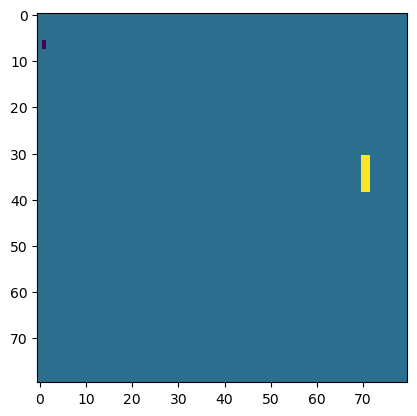

In [7]:
obs, info = env.reset()
#env.step(1)
plt.imshow(preprocess_single(obs))#, cmap='Greys')

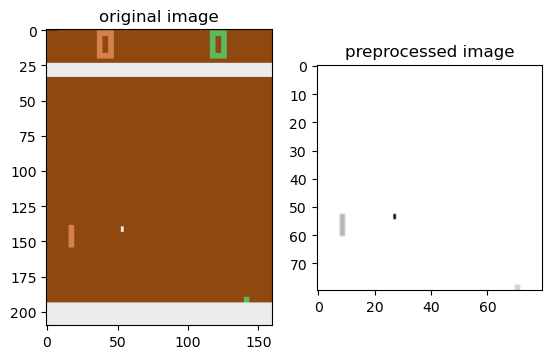

In [8]:

# show what a preprocessed image looks like
obs, info = env.reset()
_, _, _, _, _ = env.step(0)
# get a frame after 20 steps
for _ in range(20):
    frame, _, _, _, _ = env.step(np.random.choice([0,4,5]))

plt.subplot(1,2,1)
plt.imshow(frame)
plt.title('original image')

plt.subplot(1,2,2)
plt.title('preprocessed image')

# 80 x 80 black and white image
plt.imshow(preprocess_single(frame), cmap='Greys')
plt.show()



# Policy

## Exercise 1: Implement your policy
 
Here, we define our policy. The input is the stack of two different frames (which captures the movement), and the output is a number $P_{\rm right}$, the probability of moving left. Note that $P_{\rm left}= 1-P_{\rm right}$

In [9]:
# set up a convolutional neural net
# the output is the probability of moving right
# P(left) = 1-P(right)
class Policy(nn.Module):

    def __init__(self):
        super(Policy, self).__init__()
        
    ########
    ## 
    ## Modify your neural network
    ##
    ########
        
        # 80x80 to outputsize x outputsize
        # outputsize = (inputsize - kernel_size + stride)/stride 
        # (round up if not an integer)

        # output = 9x9 here
        self.conv1 = nn.Conv2d(2, 32, kernel_size=5, stride=3, padding=1)
        self.conv2 = nn.Conv2d(32, 16, kernel_size=4, stride=3, padding=1)
        self.size=16*9*9
        
        # 1 fully connected layer
        self.fc1 = nn.Linear(self.size, 32)
        self.fc2 = nn.Linear(32, 1)
        self.sig = nn.Sigmoid()
        
    def forward(self, x):
    # incoming size like: [478, 12, 2, 80, 80]
    ########
    ## 
    ## Modify your neural network
    ##
    ########

        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        # flatten the tensor
        x = x.view(-1,self.size)
        x = F.relu(self.fc1(x))
        return self.sig(self.fc2(x))
    

class Policy_Solution(nn.Module):
    def __init__(self):
        super(Policy_Solution, self).__init__()
        # 80x80x2 to 38x38x4
        # 2 channel from the stacked frame
        self.conv1 = nn.Conv2d(2, 4, kernel_size=6, stride=2, bias=False)
        # 38x38x4 to 9x9x32
        self.conv2 = nn.Conv2d(4, 16, kernel_size=6, stride=4)
        self.size=9*9*16
        
        # two fully connected layer
        self.fc1 = nn.Linear(self.size, 32)
        self.fc2 = nn.Linear(32, 1)

        # Sigmoid to 
        self.sig = nn.Sigmoid()
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = x.view(-1,self.size)
        x = F.relu(self.fc1(x))
        return self.sig(self.fc2(x))

In [10]:
# use your own policy!
policy=Policy().to(device)

#import pong_utils
#policy=pong_utils.Policy().to(device)

# we use the adam optimizer with learning rate 2e-4
# optim.SGD is also possible
import torch.optim as optim
optimizer = optim.Adam(policy.parameters(), lr=1e-4)

# Game visualization
pong_utils contain a play function given the environment and a policy. An optional preprocess function can be supplied. Here we define a function that plays a game and shows learning progress

In [11]:
#play(env, policy, time=100) 
# try to add the option "preprocess=pong_utils.preprocess_single"
# to see what the agent sees

Frame 1 done at step 451


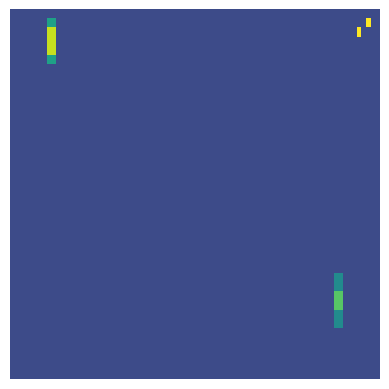

In [12]:
seed=1234
steps = 1800
frame, _ = env.reset(seed=seed)
frame = preprocess_single(frame)
img = plt.imshow(frame)
action =  np.random.choice([RIGHT, LEFT])   

for t in range(steps):
#try:
    frame1, reward1, is_done, is_trunc, info = env.step(action)
    if is_done or is_trunc:
        print("Frame 1 done at step", t)
        break 
    frame2, reward2, is_done, is_trunc, info = env.step(0)
#except:
#    print("Env Exception")
#    break
#finally:
#    try:
    frame = preprocess_batch(np.asarray([frame1, frame2]))
    framesor = torch.from_numpy(frame).float().to(device)

    # probs will only be used as the pi_old no gradient propagation is needed "so we move it to the cpu"
    # where and where not to no_grad..?
    policy.eval()
    with torch.no_grad():
        prob = policy(framesor).squeeze()#) # n polprobs
    policy.train()

    action = RIGHT if random.random() < prob else LEFT
    frame = np.mean(frame.squeeze(), axis=0) #now shape is (80,80)
#    except:
#        print("Frame Exception")
#        break

    #try:
    img.set_data(frame)   #frame.detach().cpu().numpy()) 
    plt.axis('off')
    display(plt.gcf())   #
    display(clear=True)

    if is_done or is_trunc:
        print("Game over at step", t)
        break 
    #except:
    #    print("Display Exception")
    #    break

    #finally:
    #    print("Finally")
    #    break

# Rollout  >>> `obs, rews, dones, infos = zip(*results)` <<<

Before we start the training, we need to collect samples. To make things efficient we use parallelized environments to collect multiple examples at once

In [13]:
import time
start = time.time()

nenvs = 10
envs = parallelEnv('PongDeterministic-v4', n=nenvs, seed=1234)
envtime = time.time()
print("Envs time: {:7.3f} sec".format(envtime-start))

try:
    states, actions, reward_list, polprobs, probs = collect_trajectories(envs, policy, max_steps=1000, nrand=8)
    #pass
except:
    print("Collection problem...")
    
coltime = time.time()
print("Collection time: {:7.3f} sec".format(coltime-envtime))

stop = time.time()
print("N={} Total time elapsed: {:7.3f} sec".format(nenvs, stop-start))

Envs time:   4.289 sec
Collection problem...
Collection time:   0.462 sec
N=12 Total time elapsed:   4.751 sec


In [14]:
#print("N={} Time elapsed: {:7.3f} sec".format(nenvs, stop-start))
# N=30 Time elapsed:  23.397 sec
# N=20 Time elapsed:  15.233 sec  17.732 sec
# N=15 Time elapsed:  11.687 sec  23.888 sec
# N=10 Time elapsed:   9.831 sec
# N=5 Time elapsed:   7.880 sec
# N=3 Time elapsed:   7.149 sec

In [17]:
envs.step([RIGHT]*nenvs)
#plt.imshow(frames[-1])

BrokenPipeError: [WinError 232] The pipe is being closed

# Function Definitions
Here you will define key functions for training. 

## Exercise 2: write your own function for training
("this is the same as policy_loss sort of")

### REINFORCE
you have two choices (usually it's useful to divide by the time since we've normalized our rewards and the time of each trajectory is fixed)

1. $\frac{1}{T}\sum^T_t R_{t}^{\rm future}\log(\pi_{\theta'}(a_t|s_t))$
2. $\frac{1}{T}\sum^T_t R_{t}^{\rm future}\frac{\pi_{\theta'}(a_t|s_t)}{\pi_{\theta}(a_t|s_t)}$ where $\theta'=\theta$ and make sure that the no_grad is enabled when performing the division

### PPO
Later on, you'll implement the PPO algorithm as well, and the scalar function is given by
$\frac{1}{T}\sum^T_t \min\left\{R_{t}^{\rm future}\frac{\pi_{\theta'}(a_t|s_t)}{\pi_{\theta}(a_t|s_t)},R_{t}^{\rm future}{\rm clip}_{\epsilon}\!\left(\frac{\pi_{\theta'}(a_t|s_t)}{\pi_{\theta}(a_t|s_t)}\right)\right\}$

the ${\rm clip}_\epsilon$ function is implemented in pytorch as ```torch.clamp(ratio, 1-epsilon, 1+epsilon)```

In [16]:
n=len(envs.ps)
envs.reset()
    
# start all parallel agents
_, _, _, _ = envs.step([RIGHT]*n)

# perform nrand random steps
for _ in range(5):
    st1, re1, _, _ = envs.step(np.random.choice([RIGHT, LEFT, 0], n))
    st2, re2, _, _ = envs.step([0]*n)                              # n (s1, s2)

#for t in range(tmax):

    # prepare the input first as array of shape (N,2,W,H,3)
states = np.asarray( [[s1, s2] for s1, s2 in zip(st1, st2)] )    ###  np.asarray([s1, s2])
states.shape, preprocess_batch(states).shape

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (2,) + inhomogeneous part.

In [19]:


bkg_color = np.array([144, 72, 17])
input_batch = []
env.reset()
for _ in range(11):
    frame1, reward1, is_done, is_trunc, info = env.step(np.random.choice([RIGHT,LEFT,0]))
    frame2, reward2, is_done, is_trunc, info = env.step(0)
    if is_done or is_trunc: break
for _ in range(4):
    frame1, reward1, is_done, is_trunc, info = env.step(np.random.choice([RIGHT,LEFT,0]))
    frame2, reward2, is_done, is_trunc, info = env.step(0)
    input_batch.append(np.asarray([frame1, frame2]))
    if is_done or is_trunc: 
        break

print("Each pair of two states/images:", input_batch[0].shape)
#print("image input: (2, {}, {}, {}".format(*frame1.shape))
#list_of_images = np.asarray([frame1, frame2])
new_images = np.asarray(input_batch)#[0]
print("input_batch:", new_images.shape, "2 rgb images each from N envs")
if len(new_images.shape) < 5:
    new_images = np.expand_dims(new_images, 0)
    print("expand input:", new_images.shape, "2 rgb images from 1 env")
print("array_of_images:", new_images.shape," >>> tensor >>> policy fxn nn >>> action_probs")
list_of_images_skip = new_images[:, :, 34:-16:2, ::2]
print("skip/crop:", list_of_images_skip.shape, "only every other pixel, ignore top and bottom")
print("bkg_color:", bkg_color.shape, "to be subtracted from the 3 color channels in last dim")
list_of_images_minus = list_of_images_skip - bkg_color
print("minus bkg:", list_of_images_minus.shape, ">>> averaged over the 3 r, g & b channels in last dim >>>")
list_of_images_mean = np.mean(list_of_images_minus, axis=-1)/255.
print("mean and out:", list_of_images_mean.shape, "")
#batch_input = np.swapaxes(list_of_images_mean,0,1)
#print("swap and out:", batch_input.shape)
preprocess_batch(np.asarray(input_batch)).shape

Each pair of two states/images: (2, 210, 160, 3)
input_batch: (4, 2, 210, 160, 3) 2 rgb images each from N envs
array_of_images: (4, 2, 210, 160, 3)  >>> tensor >>> policy fxn nn >>> action_probs
skip/crop: (4, 2, 80, 80, 3) only every other pixel, ignore top and bottom
bkg_color: (3,) to be subtracted from the 3 color channels in last dim
minus bkg: (4, 2, 80, 80, 3) >>> averaged over the 3 r, g & b channels in last dim >>>
mean and out: (4, 2, 80, 80) 


(4, 2, 80, 80)

In [20]:
states, actions, rewards, polprobs, old_probs = collect_trajectories(envs, policy, max_steps=50)
print("states", states.shape, "actions", actions.shape, "rewards np({},{})".format(len(rewards),*rewards[0].shape), "old_probs", old_probs.shape)
new_probs = states_to_probs(policy, states)
print("new_probs", new_probs.shape)
new_probs = torch.where(actions == RIGHT, new_probs, 1.0-new_probs)
print("avg(axis=1)", torch.mean(new_probs, axis=1).shape, "avg(axis=0)", torch.mean(new_probs, axis=0).shape)

EOFError: 

In [ ]:
# return sum of log-prob divided by T
# same thing as -policy_loss
def surrogate(policy, old_probs, states, actions, rewards,
              discount = 0.995, beta=0.01):
    pass

# clipped surrogate function
# similar as -policy_loss for REINFORCE, but for PPO
def the_other_clipped_surrogate(policy, old_probs, states, actions, rewards,
                      discount=0.995,
                      epsilon=0.1, 
                      beta=0.01):

    discount = discount**np.arange(len(rewards))
    rewards = np.asarray(rewards)*discount[:,np.newaxis]
    
    # convert rewards to future rewards
    rewards_future = rewards[::-1].cumsum(axis=0)[::-1]
    
    mean = np.mean(rewards_future, axis=1)
    std = np.std(rewards_future, axis=1) + 1.0e-10

    rewards_normalized = (rewards_future - mean[:,np.newaxis])/std[:,np.newaxis]
    
    # convert everything into pytorch tensors and move to gpu if available
    actions = torch.tensor(actions, dtype=torch.int8, device=device)
    old_probs = torch.tensor(old_probs, dtype=torch.float, device=device)
    rewards = torch.tensor(rewards_normalized, dtype=torch.float, device=device)

    # convert states to policy (or probability)
    new_probs = states_to_prob(policy, states)
    new_probs = torch.where(actions == RIGHT, new_probs, 1.0-new_probs)
    
    # ratio for clipping
    ratio = new_probs/old_probs

    # clipped function
    clip = torch.clamp(ratio, ratio-epsilon, ratio+epsilon)
    clipped_surrogate = torch.min(ratio*rewards, clip*rewards)

    # include a regularization term
    # this steers new_policy towards 0.5
    # add in 1.e-10 to avoid log(0) which gives nan
    entropy = -(new_probs*torch.log(old_probs+1.e-10)+ \
               (1.0-new_probs)*torch.log(1.0-old_probs+1.e-10))

    # this returns an average of all the entries of the tensor
    # effective computing L_sur^clip / T
    # averaged over time-step and number of trajectories
    # this is desirable because we have normalized our rewards
    return torch.mean(clipped_surrogate + beta*entropy)

# Training
We are now ready to train our policy!
WARNING: make sure to turn on GPU, which also enables multicore processing. It may take up to 45 minutes even with GPU enabled, otherwise it will take much longer!

In [53]:
##################### PPO ###############################
#### WARNING: running through all 800 episodes will take 30-45 minutes

# training loop max iterations
episodes = 100
# episodes = 800

# widget bar to display progress
widget = ['training loop: ', pb.Percentage(), ' ', 
          pb.Bar(), ' ', pb.ETA() ]
timer = pb.ProgressBar(widgets=widget, maxval=episodes).start()

#envs = parallelEnv('PongDeterministic-v4', n=20, seed=1234)

discount_rate = .99
epsilon = 0.15
beta = .008
tmax = 800
SGD_epoch = 5

# keep track of progress
mean_rewards = []

for e in range(episodes):

    # collect trajectories -- lists of tensors on cuda
    states, actions, rewards, polprobs, old_probs = collect_trajectories(envs, policy, max_steps=tmax)
    # rewards and total_rewards are the only numpys    
    total_rewards = np.sum(rewards, axis=0)

    # gradient ascent step -- few enough to get up-to-date response from nn
    for _ in range(SGD_epoch):
        
        # utilize your own clipped function!
        L = -clipped_surrogate(policy, old_probs, states, actions, rewards, epsilon=epsilon, beta=beta)

        optimizer.zero_grad()
        L.backward()
        optimizer.step()
        del L             # !oh no!
    
    # the clipping parameter reduces as episodes are collected
    epsilon*=.999
    
    # the regulation term also reduces with use
    # this reduces exploration in later runs
    beta*=.998
    
    # get the average reward of the parallel environments
    mean_rewards.append(np.mean(total_rewards))
    
    # display some progress every 20 iterations
    if (e+1)%20 ==0 :
        print("Episode: {0:d}, score: {1:f}".format(e+1, np.mean(total_rewards)))
        print(total_rewards)
        
    # update progress widget bar
    timer.update(e+1)
    
timer.finish()

BrokenPipeError: [WinError 232] The pipe is being closed

In [ ]:
# play game after training!
#play(env, policy, time=100) 
polprobs

In [ ]:
plt.plot(mean_rewards)

In [ ]:
# save your policy!
#torch.save(policy, 'data/in_training_PPO.policy')
#torch.save(policy, 'data/trained_PPO.policy')

# load your policy if needed
#policy = torch.load('data/PPO_high.policy')

# try and test out the solution!
#policy = torch.load('data/PPO_OG.policy')

Game over at step 395


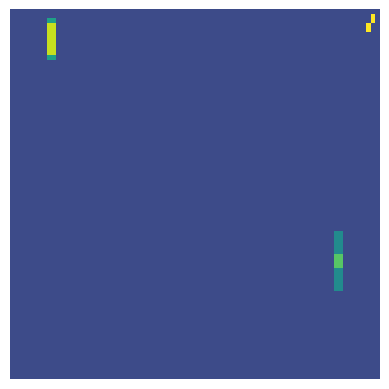

In [26]:
seed=1234
steps = 1800
frame, _ = env.reset(seed=seed)
frame = preprocess_single(frame)
img = plt.imshow(frame)
action =  np.random.choice([RIGHT, LEFT])   

for t in range(steps):
    frame1, reward1, is_done, is_trunc, info = env.step(action)
    if is_done or is_trunc:
        print("Frame 1 done at step", t)
        break 
    frame2, reward2, is_done, is_trunc, info = env.step(0)

    frame = preprocess_batch(np.asarray([frame1, frame2]))
    framesor = torch.from_numpy(frame).float().to(device)

    # probs will only be used as the pi_old no gradient propagation is needed "so we move it to the cpu"
    # where and where not to no_grad..?
    policy.eval()
    with torch.no_grad():
        prob = policy(framesor).squeeze()#) # n polprobs
    policy.train()

    action = RIGHT if random.random() < prob else LEFT
    frame = np.mean(frame.squeeze(), axis=0) #now shape is (80,80)

    img.set_data(frame)   #frame.detach().cpu().numpy()) 
    plt.axis('off')
    display(plt.gcf())   #
    display(clear=True)

    if is_done or is_trunc:
        print("Game over at step", t)
        break 


In [ ]:
seed=1234
steps = 1800
env = gym.make('PongDeterministic-v4', render_mode='rgb_array')
frame, _ = env.reset()#seed=seed)
#print(frames.shape)
frame = preprocess_single(frame)
#print(frame.shape)
img = plt.imshow(frame)
action =  np.random.choice([RIGHT, LEFT])   
for t in range(steps):
    frame1, reward1, is_done, is_trunc, info = env.step(action)
    frame2, reward2, is_done, is_trunc, info = env.step(0)
    is_done = is_done or is_trunc
    
    frame = preprocess_batch(np.asarray([frame1//2, frame2]))
    framesor = torch.from_numpy(frame).float().to(device)
        
    # probs will only be used as the pi_old no gradient propagation is needed so we move it to the cpu
    policy.eval()
    with torch.no_grad():
        prob = policy(framesor).squeeze()#) # n polprobs
    policy.train()
    
    action = RIGHT if random.random() < prob else LEFT

    frame = np.mean(frame.squeeze(), axis=0) #now shape is (80,80)
    img.set_data(frame)   #frame.detach().cpu().numpy()) 
    plt.axis('off')
    display(plt.gcf())   #
    display(clear=True)

    if is_done:
        print("Game over at step", t)
        break 